In [8]:
import pandas as pd

df= pd.read_csv("weatherHistory.csv")

In [9]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [10]:
df.tail()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.
96452,2016-09-09 23:00:00.000 +0200,Partly Cloudy,rain,20.438889,20.438889,0.61,5.8765,39.0,15.5204,0.0,1016.16,Partly cloudy starting in the morning.


In [11]:
import numpy as np
import pandas as pd
from collections import Counter


DATA_PATH = 'weatherHistory.csv'
N_STATES = 3
N_ITER = 40
TEST_DAYS = 365
SEED = 42


np.random.seed(SEED)


def coarse_summary(s):
    s = str(s).lower()
    if 'rain' in s or 'drizzle' in s: return 'rain'
    if 'snow' in s or 'sleet' in s: return 'snow'
    if 'clear' in s or 'sun' in s: return 'clear'
    if 'cloud' in s or 'overcast' in s or 'partly' in s: return 'cloudy'
    if 'fog' in s or 'mist' in s: return 'fog'
    return 'other'


df = pd.read_csv(DATA_PATH)
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True)
df = df.dropna(subset=['Formatted Date']).copy()
df['date'] = df['Formatted Date'].dt.date
df['obs_coarse'] = df['Summary'].apply(coarse_summary)


daily = df.groupby('date')['obs_coarse'].agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
daily = daily.sort_values('date').reset_index(drop=True)


obs_list = sorted(daily['obs_coarse'].unique())
obs2i = {o:i for i,o in enumerate(obs_list)}
i2obs = {i:o for o,i in obs2i.items()}
sequence = daily['obs_coarse'].map(obs2i).values

print("Observation categories:", obs_list)
print("Total days:", len(sequence))


def random_normalized(n):
    v = np.random.rand(n)
    return v / v.sum()

def initialize_hmm(n_states, n_obs):
    pi = random_normalized(n_states)
    A = np.vstack([random_normalized(n_states) for _ in range(n_states)])
    B = np.vstack([random_normalized(n_obs) for _ in range(n_states)])
    return pi, A, B

def forward(obs, pi, A, B):
    T, N = len(obs), A.shape[0]
    alpha = np.zeros((T, N))
    scale = np.zeros(T)
    alpha[0] = pi * B[:, obs[0]]
    scale[0] = alpha[0].sum(); alpha[0] /= scale[0]
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs[t]]
        scale[t] = alpha[t].sum()
        alpha[t] /= scale[t]
    return alpha, scale

def backward(obs, A, B, scale):
    T, N = len(obs), A.shape[0]
    beta = np.zeros((T, N))
    beta[-1] = 1.0 / scale[-1]
    for t in range(T-2, -1, -1):
        beta[t] = (A @ (B[:, obs[t+1]] * beta[t+1])) / scale[t]
    return beta

def baum_welch(obs, n_states, n_obs, n_iter=20):
    pi, A, B = initialize_hmm(n_states, n_obs)
    T = len(obs)
    for _ in range(n_iter):
        alpha, scale = forward(obs, pi, A, B)
        beta = backward(obs, A, B, scale)
        # expectations
        xi = np.zeros((T-1, n_states, n_states))
        for t in range(T-1):
            numer = (alpha[t][:,None] * A * (B[:, obs[t+1]] * beta[t+1])[None,:])
            xi[t] = numer / numer.sum()
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)
        # update
        pi = gamma[0]
        A = xi.sum(axis=0); A /= A.sum(axis=1, keepdims=True)
        B = np.zeros_like(B)
        for k in range(n_obs):
            mask = (obs == k)
            if mask.any(): B[:,k] = gamma[mask].sum(axis=0)
        B /= B.sum(axis=1, keepdims=True)
    return pi, A, B

def viterbi(obs, pi, A, B):
    T, N = len(obs), A.shape[0]
    delta = np.zeros((T, N)); psi = np.zeros((T, N), dtype=int)
    delta[0] = np.log(pi+1e-12) + np.log(B[:,obs[0]]+1e-12)
    for t in range(1,T):
        for j in range(N):
            seq = delta[t-1] + np.log(A[:,j]+1e-12)
            psi[t,j] = np.argmax(seq)
            delta[t,j] = seq[psi[t,j]] + np.log(B[j,obs[t]]+1e-12)
    states = np.zeros(T,dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2,-1,-1):
        states[t] = psi[t+1,states[t+1]]
    return states

# ---- Train/Test split ----
train_seq = sequence[:-TEST_DAYS]
test_seq  = sequence[-TEST_DAYS:]

# Train HMM
pi, A, B = baum_welch(train_seq, N_STATES, len(obs_list), n_iter=N_ITER)
print("\nTrained HMM Parameters:")
print("Initial:", pi)
print("Transition:\n", A)
print("Emission:\n", B)

# Decode full sequence with Viterbi
states = viterbi(sequence, pi, A, B)
daily['state'] = states

# ---- Forecasting ----
# One-step-ahead prediction: use last state to predict tomorrow
preds, actuals = [], []
for t in range(len(train_seq), len(sequence)-1):
    st = states[t]
    next_state = np.argmax(A[st])          # most likely next state
    pred_obs = np.argmax(B[next_state])    # most likely observation
    preds.append(pred_obs)
    actuals.append(sequence[t+1])

# Accuracy
preds, actuals = np.array(preds), np.array(actuals)
acc = (preds == actuals).mean()
print(f"\nForecast Accuracy on {TEST_DAYS} test days: {acc*100:.2f}%")

# Show sample predictions
for i in range(10):
    print(f"Day {i+1} actual: {i2obs[actuals[i]]} | predicted: {i2obs[preds[i]]}")


Observation categories: ['clear', 'cloudy', 'fog', 'other', 'rain']
Total days: 4019

Trained HMM Parameters:
Initial: [1.04766438e-28 1.00000000e+00 1.85054916e-23]
Transition:
 [[0.61365763 0.3622222  0.02412017]
 [0.02587833 0.96550225 0.00861942]
 [0.00764423 0.03735513 0.95500065]]
Emission:
 [[8.14538827e-01 1.57732005e-01 2.27591836e-02 4.96998405e-03
  0.00000000e+00]
 [1.53158536e-02 9.79560880e-01 5.12326648e-03 1.68983738e-34
  0.00000000e+00]
 [1.88233302e-02 6.99144424e-01 2.82032246e-01 2.25475671e-57
  0.00000000e+00]]

Forecast Accuracy on 365 test days: 93.68%
Day 1 actual: cloudy | predicted: cloudy
Day 2 actual: cloudy | predicted: cloudy
Day 3 actual: cloudy | predicted: cloudy
Day 4 actual: fog | predicted: cloudy
Day 5 actual: fog | predicted: cloudy
Day 6 actual: fog | predicted: cloudy
Day 7 actual: cloudy | predicted: cloudy
Day 8 actual: cloudy | predicted: cloudy
Day 9 actual: cloudy | predicted: cloudy
Day 10 actual: cloudy | predicted: cloudy


In [12]:
from hmmlearn import hmm

Observation categories: ['clear', 'cloudy', 'fog', 'other', 'rain']
Total days: 4019
Train days: 3654 Test days: 365
Iter 1/40, log-scale-likelihood: -6471.5832
Iter 6/40, log-scale-likelihood: -1496.6129
Iter 11/40, log-scale-likelihood: -1397.2829
Iter 16/40, log-scale-likelihood: -1343.8494
Iter 21/40, log-scale-likelihood: -1317.1511
Iter 26/40, log-scale-likelihood: -1307.8088
Iter 31/40, log-scale-likelihood: -1304.2223
Iter 36/40, log-scale-likelihood: -1303.3070
Iter 40/40, log-scale-likelihood: -1303.0657

Trained HMM Parameters:
Initial (pi): [0. 1. 0.]
Transition (A):
 [[0.6135 0.3625 0.0241]
 [0.0259 0.9655 0.0086]
 [0.0076 0.0374 0.955 ]]
Emission (B):
 [[0.8143 0.158  0.0228 0.005  0.    ]
 [0.0153 0.9796 0.0051 0.     0.    ]
 [0.0188 0.6991 0.2821 0.     0.    ]]

One-step-ahead Forecast Overall Accuracy on 365 test days: 93.70%
Per-class accuracy (by observation label):
  clear  :  44.44%  (count=9)
  cloudy :  98.83%  (count=342)
  fog    :   0.00%  (count=10)
  other

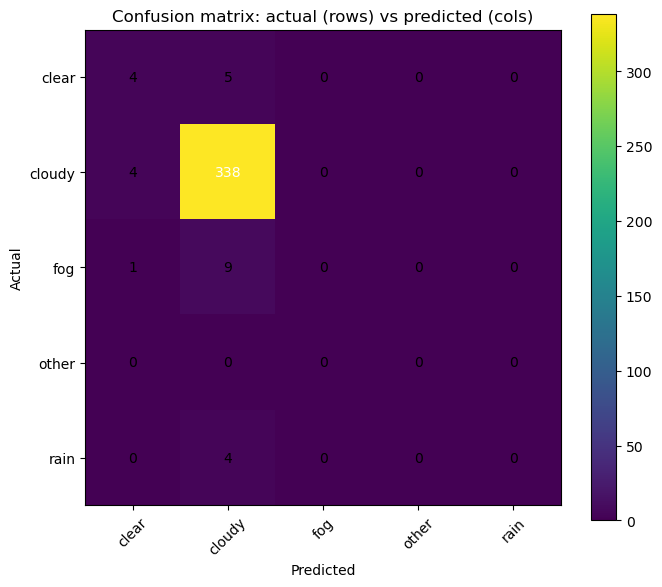

In [13]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle, os

DATA_PATH = 'weatherHistory.csv' 
N_STATES = 3
N_ITER = 40
TEST_DAYS = 365
SEED = 42
SAVE_MODEL = False
MODEL_PATH = 'hmm_weather.pkl'
np.random.seed(SEED)

def coarse_summary(s):
    s = str(s).lower()
    if 'rain' in s or 'drizzle' in s: return 'rain'
    if 'snow' in s or 'sleet' in s: return 'snow'
    if 'clear' in s or 'sun' in s: return 'clear'
    if 'cloud' in s or 'overcast' in s or 'partly' in s: return 'cloudy'
    if 'fog' in s or 'mist' in s: return 'fog'
    return 'other'

def random_normalized(n):
    v = np.random.rand(n) + 1e-3  # avoid zeros
    return v / v.sum()

# HMM Initialization 
def initialize_hmm(n_states, n_obs):
    pi = random_normalized(n_states)
    A = np.vstack([random_normalized(n_states) for _ in range(n_states)])
    B = np.vstack([random_normalized(n_obs) for _ in range(n_states)])
    return pi, A, B

# Forward (scaled)
def forward(obs, pi, A, B):
    T, N = len(obs), A.shape[0]
    alpha = np.zeros((T, N))
    scale = np.zeros(T)
    # initialize
    alpha[0] = pi * B[:, obs[0]]
    scale[0] = alpha[0].sum()
    if scale[0] == 0: scale[0] = 1e-12
    alpha[0] /= scale[0]
    # recursion
    for t in range(1, T):
        alpha[t] = (alpha[t-1] @ A) * B[:, obs[t]]
        scale[t] = alpha[t].sum()
        if scale[t] == 0: scale[t] = 1e-12
        alpha[t] /= scale[t]
    return alpha, scale

# Backward (scaled)
def backward(obs, A, B, scale):
    T, N = len(obs), A.shape[0]
    beta = np.zeros((T, N))
    beta[-1] = 1.0 / scale[-1]
    for t in range(T-2, -1, -1):
        beta[t] = (A @ (B[:, obs[t+1]] * beta[t+1])) / scale[t]
    return beta

# Baum-Welch (EM)
def baum_welch(obs, n_states, n_obs, n_iter=20, verbose=False):
    pi, A, B = initialize_hmm(n_states, n_obs)
    T = len(obs)
    for it in range(n_iter):
        alpha, scale = forward(obs, pi, A, B)
        beta = backward(obs, A, B, scale)

        # compute xi and gamma
        xi = np.zeros((T-1, n_states, n_states))
        for t in range(T-1):
            # numer: alpha[t,i] * A[i,j] * B[j,obs[t+1]] * beta[t+1,j]
            numer = (alpha[t][:, None] * A) * (B[:, obs[t+1]] * beta[t+1])[None, :]
            denom = numer.sum()
            if denom == 0:
                # fallback to small uniform to avoid NaNs
                xi[t] = np.ones((n_states,n_states)) / (n_states*n_states)
            else:
                xi[t] = numer / denom

        gamma = (alpha * beta)
        # normalize gamma rows
        row_sums = gamma.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-12
        gamma /= row_sums

        # M-step
        pi = gamma[0]
        A = xi.sum(axis=0)
        # normalize rows of A
        A_row_sums = A.sum(axis=1, keepdims=True)
        A_row_sums[A_row_sums == 0] = 1e-12
        A = A / A_row_sums

        B = np.zeros_like(B)
        for k in range(n_obs):
            mask = (obs == k)
            if mask.any():
                B[:, k] = gamma[mask].sum(axis=0)
        B_row_sums = B.sum(axis=1, keepdims=True)
        B_row_sums[B_row_sums == 0] = 1e-12
        B = B / B_row_sums

        if verbose and (it % 5 == 0 or it == n_iter-1):
            loglik = np.log(scale).sum()
            print(f"Iter {it+1}/{n_iter}, log-scale-likelihood: {loglik:.4f}")

    return pi, A, B

# Viterbi (log-space) 
def viterbi(obs, pi, A, B):
    T, N = len(obs), A.shape[0]
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)
    tiny = 1e-12
    log_pi = np.log(pi + tiny)
    log_A = np.log(A + tiny)
    log_B = np.log(B + tiny)

    delta[0] = log_pi + log_B[:, obs[0]]
    for t in range(1, T):
        for j in range(N):
            seq = delta[t-1] + log_A[:, j]
            psi[t, j] = np.argmax(seq)
            delta[t, j] = seq[psi[t, j]] + log_B[j, obs[t]]

    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

# ----------------- Metrics & Confusion -----------------
def confusion_matrix_and_metrics(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for a, p in zip(y_true, y_pred):
        cm[a, p] += 1
    per_class_acc = np.zeros(n_classes)
    for i in range(n_classes):
        total = cm[i].sum()
        per_class_acc[i] = (cm[i,i] / total) if total > 0 else np.nan
    overall_acc = np.trace(cm) / cm.sum() if cm.sum() > 0 else 0.0
    return cm, per_class_acc, overall_acc

# ----------------- MAIN: load, preprocess, split, train, eval -----------------
def main():
    # Load & preprocess
    df = pd.read_csv(DATA_PATH)
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True)
    df = df.dropna(subset=['Formatted Date']).copy()
    df['date'] = df['Formatted Date'].dt.date
    df['obs_coarse'] = df['Summary'].apply(coarse_summary)
    daily = df.groupby('date')['obs_coarse'].agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
    daily = daily.sort_values('date').reset_index(drop=True)

    obs_list = sorted(daily['obs_coarse'].unique())
    obs2i = {o:i for i,o in enumerate(obs_list)}
    i2obs = {i:o for o,i in obs2i.items()}
    sequence = daily['obs_coarse'].map(obs2i).values
    print("Observation categories:", obs_list)
    print("Total days:", len(sequence))

    # Train/Test split
    if TEST_DAYS >= len(sequence):
        raise ValueError("TEST_DAYS must be smaller than total days in dataset.")
    train_seq = sequence[:-TEST_DAYS]
    test_seq  = sequence[-TEST_DAYS:]
    print("Train days:", len(train_seq), "Test days:", len(test_seq))

    # Train HMM on train_seq
    pi, A, B = baum_welch(train_seq, N_STATES, len(obs_list), n_iter=N_ITER, verbose=True)
    print("\nTrained HMM Parameters:")
    print("Initial (pi):", np.round(pi,4))
    print("Transition (A):\n", np.round(A,4))
    print("Emission (B):\n", np.round(B,4))

    if SAVE_MODEL:
        with open(MODEL_PATH, 'wb') as f:
            pickle.dump({'pi':pi,'A':A,'B':B,'obs_list':obs_list,'obs2i':obs2i,'i2obs':i2obs}, f)
        print(f"Saved model to {MODEL_PATH}")

    # Run Viterbi on the entire sequence for state decoding (alternatively you can decode only train or test)
    states = viterbi(sequence, pi, A, B)

    # Forecasting on test set (one-step-ahead) using decoded states:
    preds = []
    actuals = []
    # We'll use the state inferred at test start and move forward along A for predictions
    test_start_idx = len(train_seq) - 1  # index of the last train day (we predict from here to predict test[0])
    # If there are insufficient decoded states (edge-case), fall back to using most probable state
    if test_start_idx < 0:
        test_start_idx = 0
    for i in range(len(test_seq)):
        t = len(train_seq) + i - 1  # index in full sequence whose state we use to predict next
        if t < 0:
            current_state = np.argmax(pi)
        else:
            current_state = states[t]
        # choose most likely next state, then most likely observation from that state
        next_state = np.argmax(A[current_state])
        pred_obs = np.argmax(B[next_state])
        preds.append(pred_obs)
        actuals.append(test_seq[i])

    preds = np.array(preds)
    actuals = np.array(actuals)
    # Metrics
    cm, per_class_acc, overall_acc = confusion_matrix_and_metrics(actuals, preds, len(obs_list))
    print(f"\nOne-step-ahead Forecast Overall Accuracy on {len(test_seq)} test days: {overall_acc*100:.2f}%")
    print("Per-class accuracy (by observation label):")
    for i, lab in i2obs.items():
        print(f"  {lab:7s}: {per_class_acc[i]*100 if not np.isnan(per_class_acc[i]) else np.nan:6.2f}%  (count={cm[i].sum()})")

    # Show sample predictions
    print("\nSample predictions (first 10 in test set):")
    for i in range(min(10, len(preds))):
        print(f"Day {i+1} actual: {i2obs[actuals[i]]:7s} | predicted: {i2obs[preds[i]]:7s}")

    # Plot confusion matrix
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion matrix: actual (rows) vs predicted (cols)')
    plt.colorbar()
    tick_marks = np.arange(len(obs_list))
    plt.xticks(tick_marks, obs_list, rotation=45)
    plt.yticks(tick_marks, obs_list)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
